## The Training

### 1st train

Runs with data digit images only.
The best model will be stored as "dig-s1-md-best.h5"


## The Model

Used a the jomjol CNN-S1 network as small model.



In [1]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 400                     # earlystopping, see model.fit
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 32
use_grayscale = False                # grayscale or rgb
output_dir = "output/" 
output_tmp_dir = "output/tmp/"
model_filename = "dig-class100-s2"

##########################################################################

from sklearn.model_selection import train_test_split
from b2n.data.tmnist import tmnist_percentals
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import *
from sklearn.utils import shuffle
from b2n.encodings.class_encoding import *
from b2n.augmentation.generator import *
from datetime import datetime

date_time = datetime.now().strftime("%Y%m%d-%H%M%S")


#try:
    # Disable all GPUS
#    tf.config.set_visible_devices([], 'GPU')
#    visible_devices = tf.config.get_visible_devices()
#    for device in visible_devices:
#        assert device.device_type != 'GPU'
#except:
    # Invalid device or cannot modify virtual devices once initialized.
#    pass

## Load data

Like the distillation network meter digits will be trained with font builded images.

### digit meter images

The meter digits are all 0-9 ziffer_raw (https://github.com/jomjol/neural-network-autotrain-digital-counter/tree/main/ziffer_raw) and other collected data (used https://github.com/haverland/collectmeterdigits).

### Train and Test data

For 1st train the digit meter will be used.

### digit meter spread

The images of digit meters are collected and labeled by hand. So the image count of labels are differnt. The meter digit spread plot shows the count for each label.

Ziffer data count:  20352
dataset x_train-size=20352


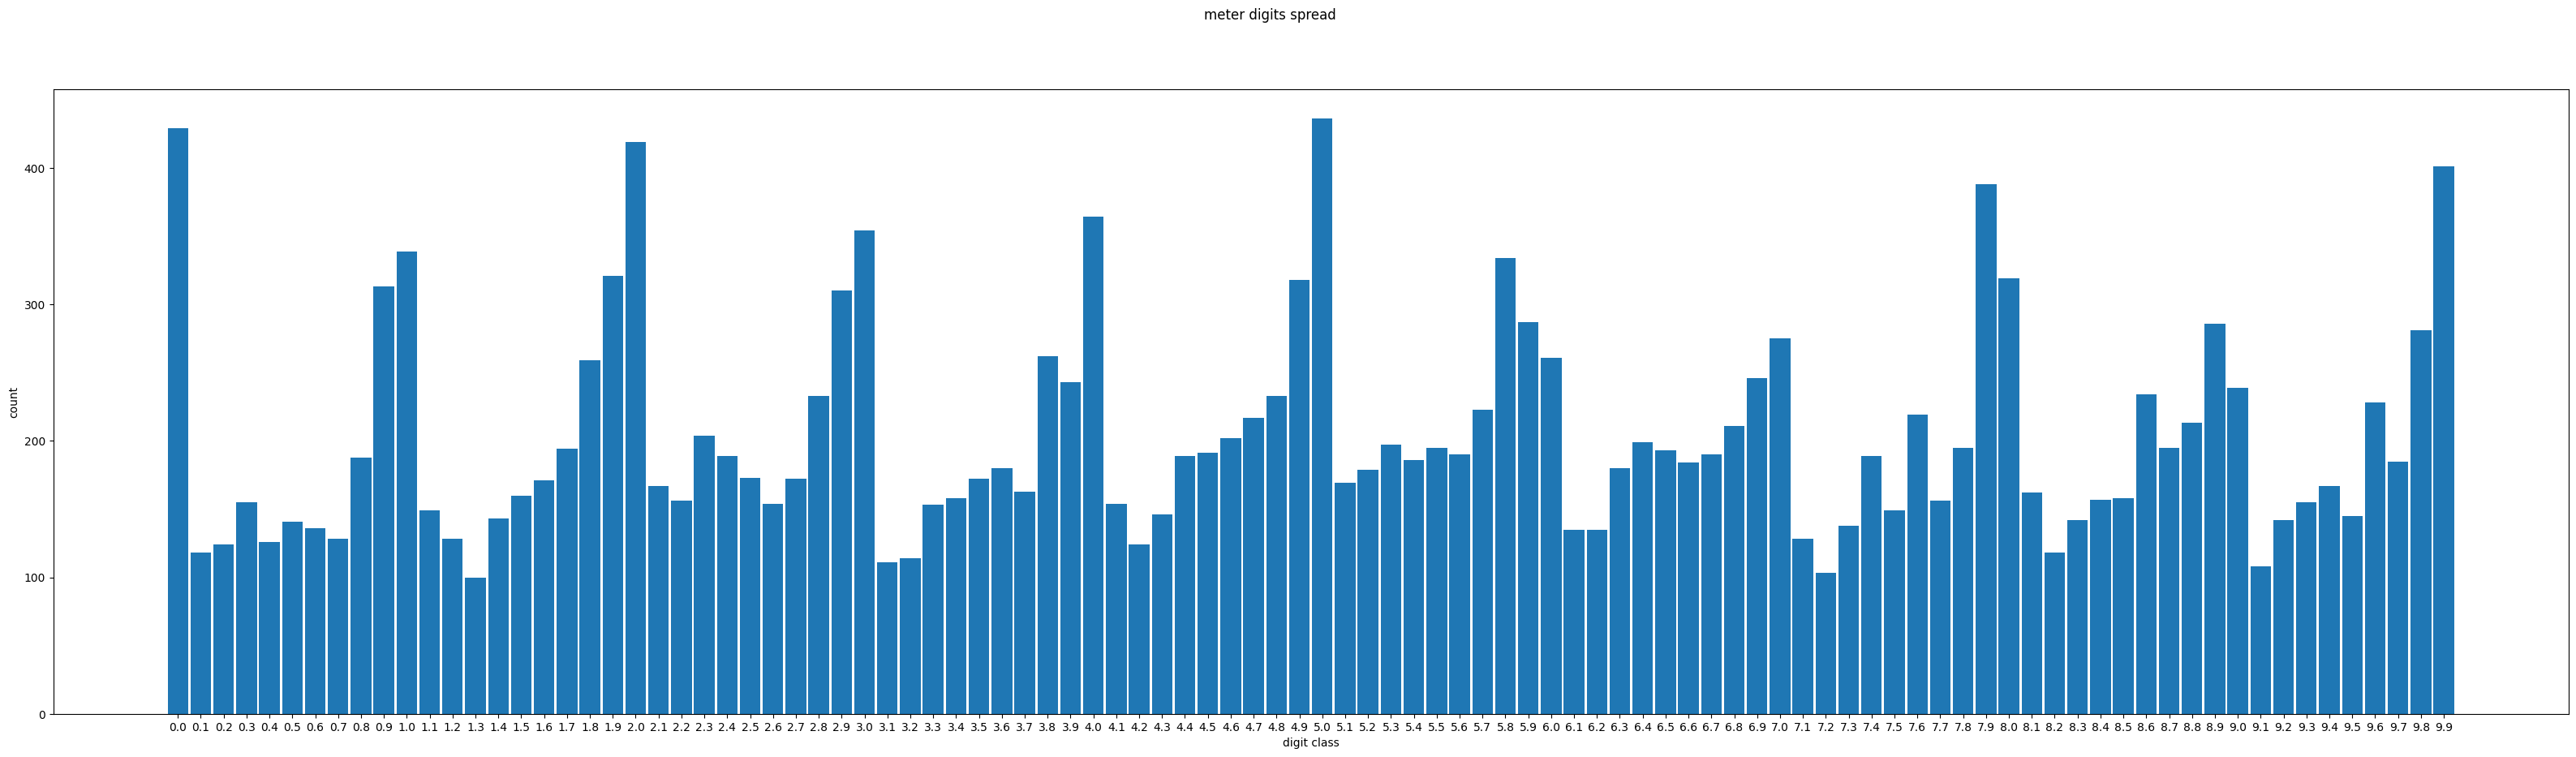

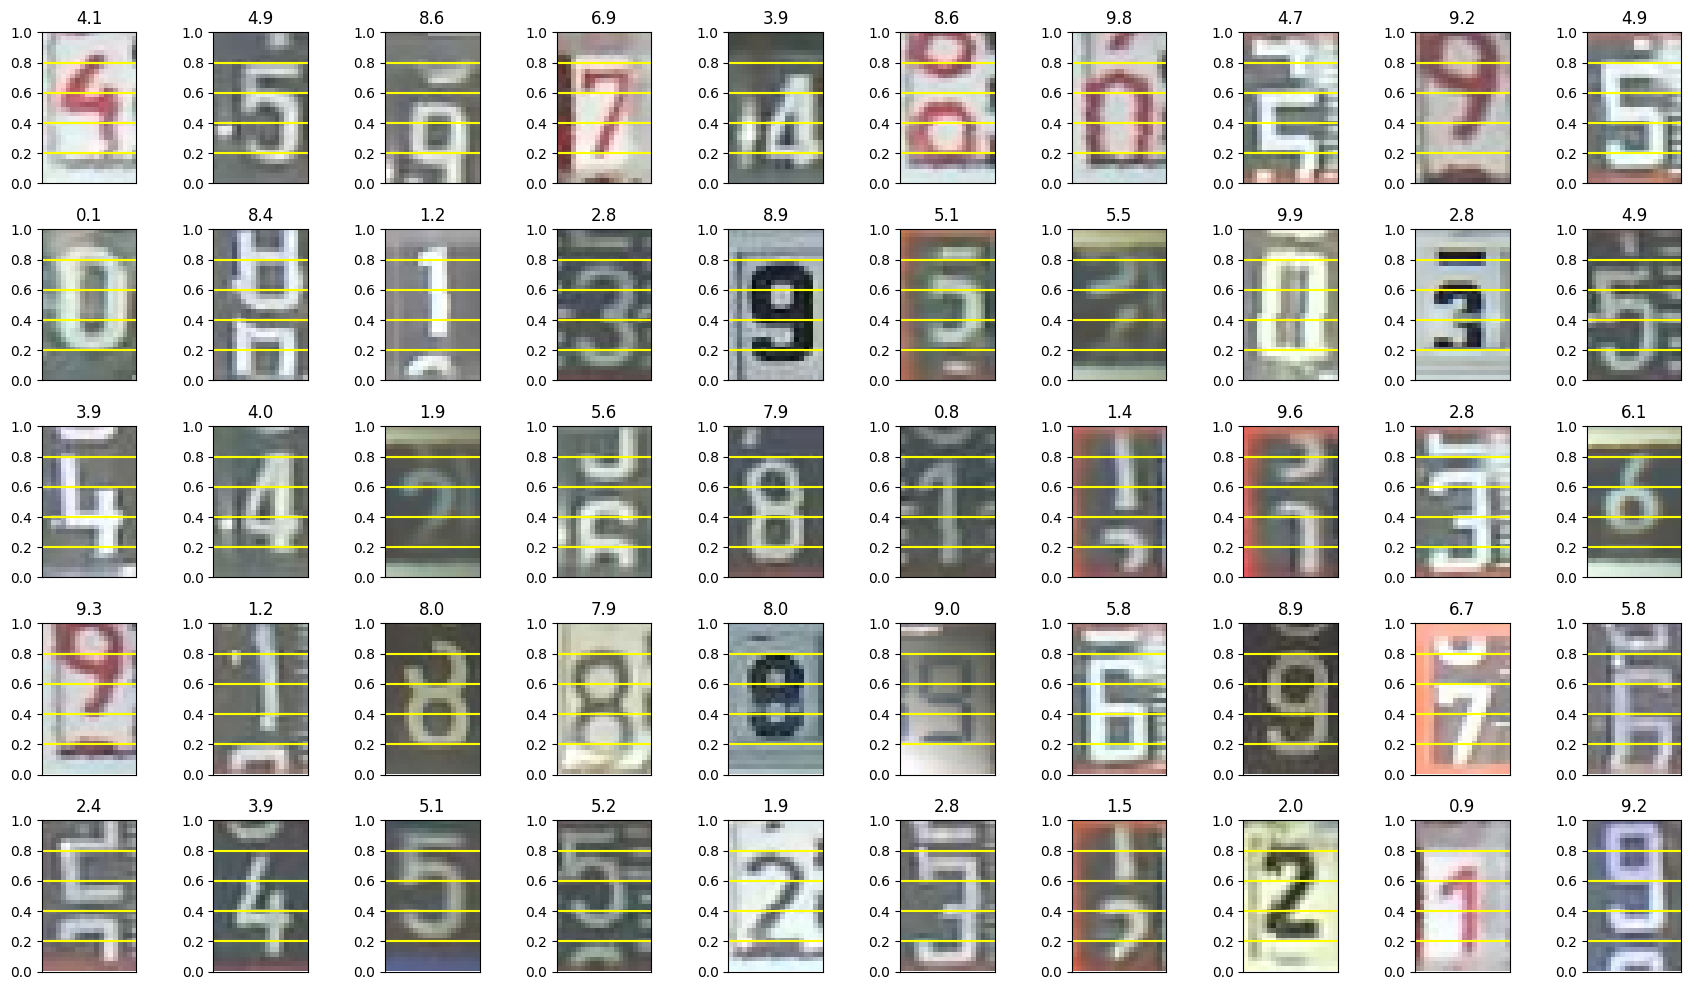

In [2]:


xz_data, yz_data, fz_data = ziffer_data(input_dir='images')

# distribution
_, inverse = np.unique(yz_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
plot_divergence(ziffer_bincount, "meter digits spread", nb_classes)


# Split train and validation data 
xz_train, yz_train = shuffle(xz_data, yz_data)
x_train, x_test, y_train, y_test = train_test_split(xz_train, yz_train, test_size=Training_Percentage)

input_shape=xz_train[0].shape
print(f"dataset x_train-size={len(xz_train)}")
plot_dataset(xz_train, yz_train)

y_train = class_encoding(y_train, nb_classes)
y_test = class_encoding(y_test, nb_classes)


### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting and noising images.

The validation set is not augmentated. It uses only meter digit images for a real result how the model fits to meter digits.
So the validation says more about the results and its easier to use a early stopping mechanism.

Train data


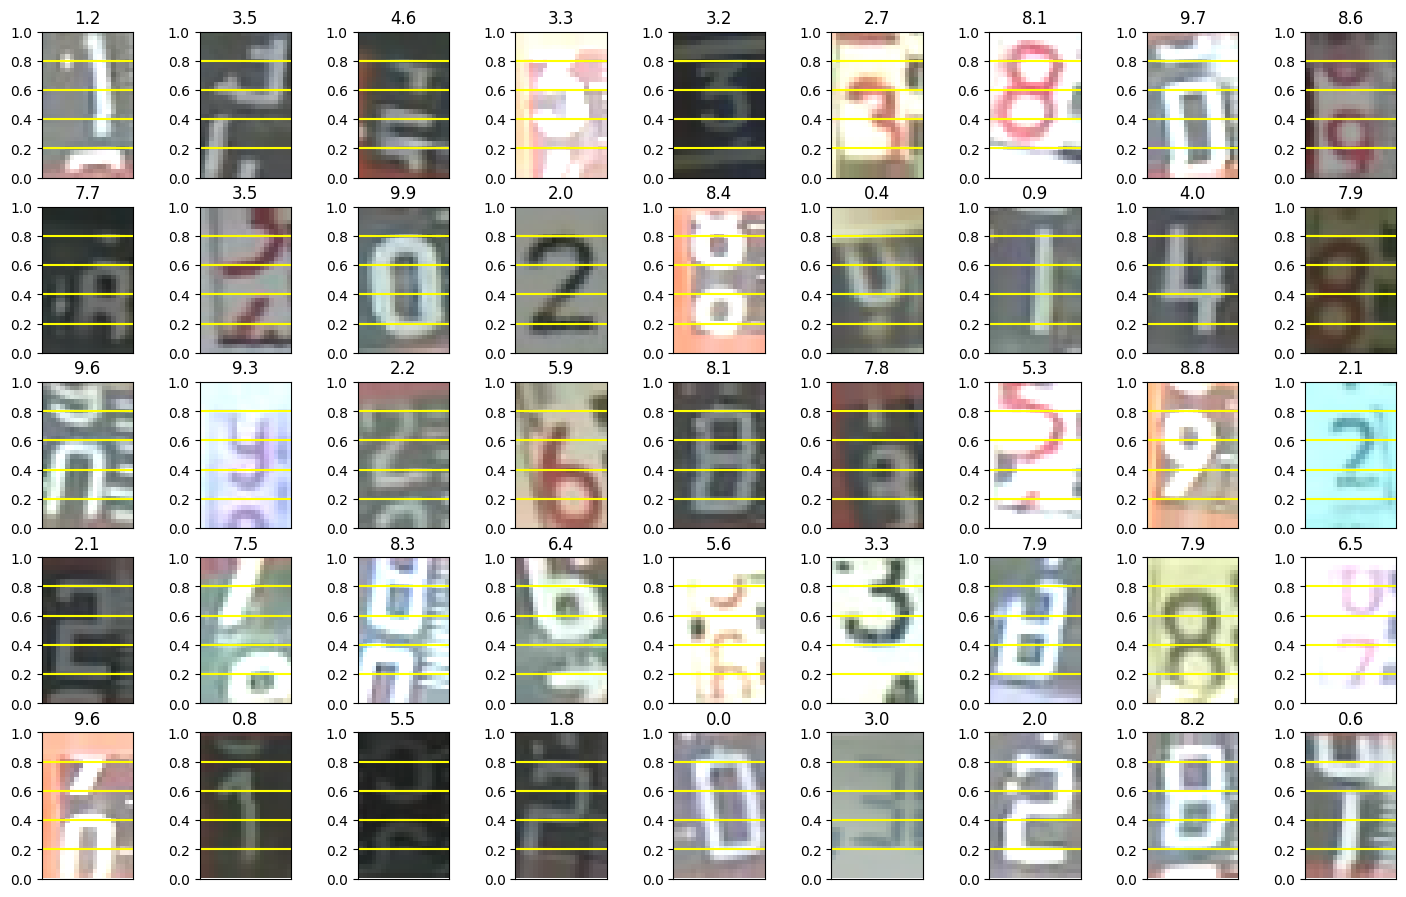

Validation data


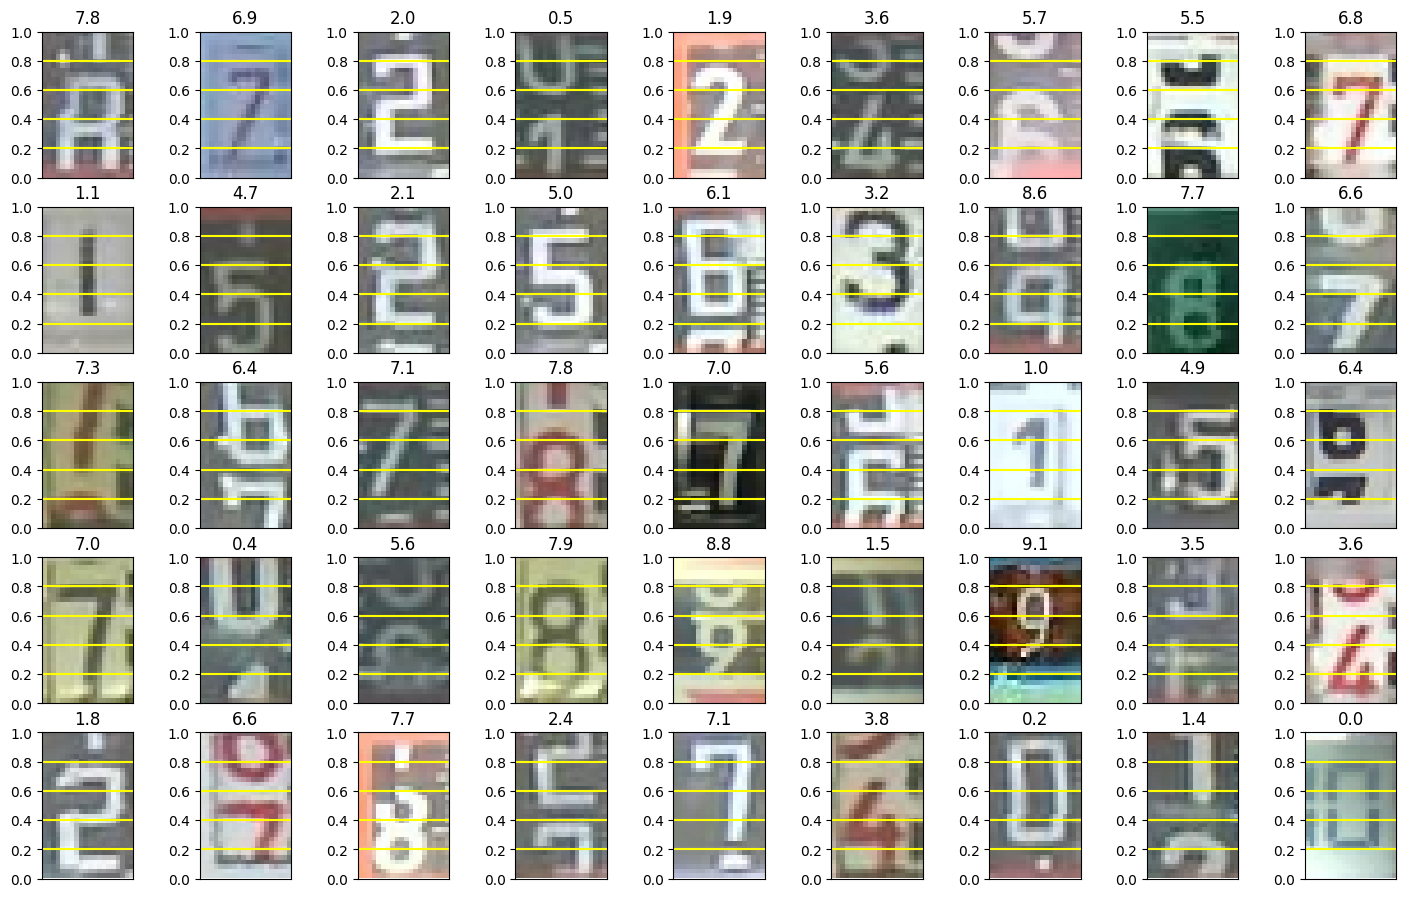

In [3]:
import numpy as np
from b2n.augmentation.generator import augmentation, no_augmentation
from b2n.plotfunctions import plot_dataset_it

train_iterator = augmentation(x_train, y_train, Batch_Size=Batch_Size,
                              Width_Shift_Range = 3, Height_Shift_Range = 0, 
                    Brightness_Range = [0.4,1.6],
                    Rotation_Angle = 10,
                    ZoomRange_Out = 0.2,
                    ZoomRange_In = 0.1,
                    ShearRange= 3,
                    Channel_Shift=0.4,
                      preprocessing_function=None)
validation_iterator = no_augmentation(x_test, y_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 


### The Model

Is an small EfficientNet like model with a dense output of 100 at top. 



In [4]:
import tensorflow as tf
from b2n.models.distiller import Distiller
from b2n.models.effnet import Effnet
from b2n.models.cnn32 import *
from keras import backend as K

#def accuracy(y_true, y_pred):
#    return K.mean(K.less_equal(K.abs((K.abs(K.argmax(y_true))- K.abs(K.argmax(y_pred)))), 1 ))


model = CNN_s2(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.optimizers.legacy.Adam(learning_rate=1e-3), metrics = ["accuracy"])

model.summary()

Metal device set to: Apple M1 Pro


2023-06-06 19:57:41.923684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-06 19:57:41.923707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 20, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 20, 32)        896       
                                                                 
 batch_normalization_1 (Batc  (None, 32, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 10, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 10, 32)        0         
                                                        

### The Training

Standard training of the model with complete dataset.

The ModelCheckpoint helps to keep the best model. 

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from b2n.plotfunctions import plot_acc_loss, predict_meter_digits

#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x, verbose=0)
earlystop = EarlyStopping(monitor='val_loss', mode='min' , patience=25, verbose=1,  restore_best_weights=True)
mc = ModelCheckpoint(output_tmp_dir + model_filename + '_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, initial_value_threshold=.9)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=5, min_lr=1e-5, verbose=1)
history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[earlystop, mc, reduce_lr],
                verbose=1)


#model.save(model_filename + '.h5')

plot_acc_loss(history, "Trainingsresults")

Epoch 1/400


2023-06-06 19:57:42.208615: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-06 19:57:42.808909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


506/509 [============================>.] - ETA: 0s - loss: 4.6376 - accuracy: 0.0243

2023-06-06 19:57:51.290704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss did not improve from 0.90000
509/509 [==============================] - 10s 18ms/step - loss: 4.6357 - accuracy: 0.0246 - val_loss: 4.1446 - val_accuracy: 0.0769 - lr: 0.0010
Epoch 2/400
509/509 [==============================] - ETA: 0s - loss: 3.4375 - accuracy: 0.1456
Epoch 2: val_loss did not improve from 0.90000
509/509 [==============================] - 9s 17ms/step - loss: 3.4375 - accuracy: 0.1456 - val_loss: 1.7522 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 3/400
506/509 [============================>.] - ETA: 0s - loss: 2.2278 - accuracy: 0.3367
Epoch 3: val_loss did not improve from 0.90000
509/509 [==============================] - 9s 17ms/step - loss: 2.2266 - accuracy: 0.3368 - val_loss: 1.1357 - val_accuracy: 0.6161 - lr: 0.0010
Epoch 4/400
507/509 [============================>.] - ETA: 0s - loss: 1.7815 - accuracy: 0.4180
Epoch 4: val_loss improved from 0.90000 to 0.89547, saving model to output/tmp/dig-class100-s2_best.h5
509/509 [===================

509/509 [==============================] - 9s 17ms/step - loss: 0.9526 - accuracy: 0.6213 - val_loss: 0.6194 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 27/400
508/509 [============================>.] - ETA: 0s - loss: 0.9519 - accuracy: 0.6209
Epoch 27: val_loss improved from 0.61795 to 0.61637, saving model to output/tmp/dig-class100-s2_best.h5
509/509 [==============================] - 9s 17ms/step - loss: 0.9523 - accuracy: 0.6206 - val_loss: 0.6164 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 28/400
508/509 [============================>.] - ETA: 0s - loss: 0.9359 - accuracy: 0.6277
Epoch 28: val_loss improved from 0.61637 to 0.59858, saving model to output/tmp/dig-class100-s2_best.h5
509/509 [==============================] - 9s 17ms/step - loss: 0.9352 - accuracy: 0.6281 - val_loss: 0.5986 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 29/400
509/509 [==============================] - ETA: 0s - loss: 0.9299 - accuracy: 0.6270
Epoch 29: val_loss improved from 0.59858 to 0.59000, saving mod

509/509 [==============================] - 9s 17ms/step - loss: 0.7354 - accuracy: 0.7062 - val_loss: 0.5321 - val_accuracy: 0.7735 - lr: 7.2250e-04
Epoch 53/400
509/509 [==============================] - ETA: 0s - loss: 0.7214 - accuracy: 0.7096
Epoch 53: val_loss did not improve from 0.52322

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0006141250254586339.
509/509 [==============================] - 9s 17ms/step - loss: 0.7214 - accuracy: 0.7096 - val_loss: 0.5387 - val_accuracy: 0.7755 - lr: 7.2250e-04
Epoch 54/400
509/509 [==============================] - ETA: 0s - loss: 0.7181 - accuracy: 0.7092
Epoch 54: val_loss improved from 0.52322 to 0.51934, saving model to output/tmp/dig-class100-s2_best.h5
509/509 [==============================] - 9s 17ms/step - loss: 0.7181 - accuracy: 0.7092 - val_loss: 0.5193 - val_accuracy: 0.7821 - lr: 6.1413e-04
Epoch 55/400
508/509 [============================>.] - ETA: 0s - loss: 0.7100 - accuracy: 0.7176
Epoch 55: val_loss did not im

508/509 [============================>.] - ETA: 0s - loss: 0.6036 - accuracy: 0.7553
Epoch 78: val_loss improved from 0.46697 to 0.46576, saving model to output/tmp/dig-class100-s2_best.h5
509/509 [==============================] - 9s 17ms/step - loss: 0.6033 - accuracy: 0.7554 - val_loss: 0.4658 - val_accuracy: 0.7993 - lr: 4.4371e-04
Epoch 79/400
509/509 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.7643
Epoch 79: val_loss did not improve from 0.46576
509/509 [==============================] - 9s 17ms/step - loss: 0.5942 - accuracy: 0.7643 - val_loss: 0.4709 - val_accuracy: 0.7971 - lr: 4.4371e-04
Epoch 80/400
508/509 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.7580
Epoch 80: val_loss improved from 0.46576 to 0.45963, saving model to output/tmp/dig-class100-s2_best.h5
509/509 [==============================] - 9s 17ms/step - loss: 0.6043 - accuracy: 0.7581 - val_loss: 0.4596 - val_accuracy: 0.8086 - lr: 4.4371e-04
Epoch 81/400
509

Epoch 104/400
507/509 [============================>.] - ETA: 0s - loss: 0.5417 - accuracy: 0.7813
Epoch 104: val_loss did not improve from 0.44185
509/509 [==============================] - 9s 18ms/step - loss: 0.5418 - accuracy: 0.7814 - val_loss: 0.4438 - val_accuracy: 0.8155 - lr: 2.7249e-04
Epoch 105/400
509/509 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.7783
Epoch 105: val_loss did not improve from 0.44185

Epoch 105: ReduceLROnPlateau reducing learning rate to 0.00023161696735769509.
509/509 [==============================] - 9s 17ms/step - loss: 0.5456 - accuracy: 0.7783 - val_loss: 0.4614 - val_accuracy: 0.8010 - lr: 2.7249e-04
Epoch 106/400
509/509 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.7847
Epoch 106: val_loss did not improve from 0.44185
509/509 [==============================] - 9s 17ms/step - loss: 0.5320 - accuracy: 0.7847 - val_loss: 0.4505 - val_accuracy: 0.8106 - lr: 2.3162e-04
Epoch 107/400
507/509 [======

509/509 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.7977
Epoch 130: val_loss did not improve from 0.43472

Epoch 130: ReduceLROnPlateau reducing learning rate to 0.00014224176775314845.
509/509 [==============================] - 9s 17ms/step - loss: 0.5081 - accuracy: 0.7977 - val_loss: 0.4538 - val_accuracy: 0.8145 - lr: 1.6734e-04
Epoch 131/400
509/509 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.7960
Epoch 131: val_loss did not improve from 0.43472
509/509 [==============================] - 9s 17ms/step - loss: 0.5030 - accuracy: 0.7960 - val_loss: 0.4476 - val_accuracy: 0.8148 - lr: 1.4224e-04
Epoch 132/400
508/509 [============================>.] - ETA: 0s - loss: 0.5066 - accuracy: 0.7978
Epoch 132: val_loss did not improve from 0.43472
509/509 [==============================] - 9s 17ms/step - loss: 0.5075 - accuracy: 0.7976 - val_loss: 0.4410 - val_accuracy: 0.8204 - lr: 1.4224e-04
Epoch 133/400
509/509 [====================

Epoch 156/400
508/509 [============================>.] - ETA: 0s - loss: 0.4852 - accuracy: 0.8079
Epoch 156: val_loss did not improve from 0.43128
509/509 [==============================] - 9s 17ms/step - loss: 0.4852 - accuracy: 0.8079 - val_loss: 0.4456 - val_accuracy: 0.8160 - lr: 7.4251e-05
Epoch 157/400
509/509 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.8068
Epoch 157: val_loss did not improve from 0.43128
509/509 [==============================] - 9s 17ms/step - loss: 0.4845 - accuracy: 0.8068 - val_loss: 0.4354 - val_accuracy: 0.8190 - lr: 7.4251e-05
Epoch 158/400
507/509 [============================>.] - ETA: 1s - loss: 0.4662 - accuracy: 0.8137
Epoch 158: val_loss did not improve from 0.43128
509/509 [==============================] - 311s 612ms/step - loss: 0.4674 - accuracy: 0.8130 - val_loss: 0.4489 - val_accuracy: 0.8163 - lr: 7.4251e-05
Epoch 159/400
316/509 [=================>............] - ETA: 2s - loss: 0.4755 - accuracy: 0.8052

### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation. The first false predicted will be shown in the diagram.

In [ ]:
model = keras.models.load_model(output_tmp_dir + model_filename + '_best.h5')
false_predicted_files = predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data, 
                                            max_delta=0.11)
fpf = pd.DataFrame(false_predicted_files)

# the csv can be used with collectmeterdigits to fix labels
# python3 -m collectmeterdigits --labelfile=output/tmp/dig-class100-s2_false_predicted.csv
fpf.to_csv(output_tmp_dir + model_filename + '_false_predicted.csv')

In [ ]:
from dataclasses import dataclass
from b2n.models.prune_quantize import prune, quantization_default
from  tensorflow import keras

# prune the model
model_pruned = model
# pruning reduces the accurracy 
#model_pruned = prune(model=model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

# quanitize and save the model
tflite_model = quantization_default(model=model_pruned, 
                            x_train=x_test)
# save the model
filename=output_dir + model_filename + "_" + date_time + "_q.tflite"                                                     
open( filename, "wb").write(tflite_model)